## Import Library

In [1]:
import os
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from loguru import logger
import shap
print(f'Current working directory: {os.getcwd()}')
# change directory
os.chdir('../')
print(f'New working directory: {os.getcwd()}')

Current working directory: c:\Users\tolayi1\Documents\GitHub\compositional_model\notebooks
New working directory: c:\Users\tolayi1\Documents\GitHub\compositional_model


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Required Python Class

In [3]:
from source.dataPreprocessing import Data
from source.plotters import Plotters

## 3. Source Model

### 3.1 Load Source Data

In [4]:
random_state = 42
id = './data/processed/2024-02-15-simulated_data_Ecell_Concentrtn_no_membrane_info_CASE_3-speed-up.csv'
#id = 'data/generated/2023-11-25-simulated_data_no_Area_Rate_CASE_2.csv'
sim_data = pd.read_csv(f'{id}')
sim_data = sim_data.sample(frac=1, random_state=random_state).reset_index(drop=True)
print(sim_data.shape)
sim_data.head()

(5982, 12)


,Ecell,Dil,Conc,Ncell,T_tot,IEC_r,poros_r,dens_r,dp,SR,EC,TEE
0,0.4,3.5,2.5,1,90.0,0.57,0.243,1.404,0.57,0.223286,0.173201,0.471689
1,0.4,5.0,5.0,10,30.0,0.77,0.238,1.442,0.57,0.556324,0.201865,0.463743
2,0.4,3.5,1.0,3,90.0,0.77,0.238,1.442,0.57,0.545219,0.176736,0.415796
3,0.1,2.5,2.5,7,60.0,1.05,0.130,1.276,0.57,0.276799,0.054217,0.487327
4,2.0,1.0,3.5,1,90.0,0.77,0.238,1.442,0.57,0.786540,0.919414,0.492563


In [5]:
sim_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Ecell,5982.0,0.900502,0.722067,0.100000,0.400000,1.000000,2.000000,2.000000
Dil,5982.0,3.062423,1.432218,1.000000,2.500000,3.500000,5.000000,5.000000
Conc,5982.0,2.959502,1.453646,1.000000,1.000000,2.500000,3.500000,5.000000
Ncell,5982.0,5.243731,3.483706,1.000000,3.000000,4.000000,7.000000,10.000000
T_tot,5982.0,75.000000,33.600971,15.000000,45.000000,75.000000,105.000000,165.000000
IEC_r,5982.0,0.645961,0.322268,0.000000,0.570000,0.770000,0.790000,1.050000
poros_r,5982.0,0.343001,0.296322,0.130000,0.186000,0.238000,0.265000,1.000000
dens_r,5982.0,1.140582,0.511157,0.000000,1.276000,1.348000,1.404000,1.442000
dp,5982.0,0.475476,0.212017,0.000000,0.570000,0.570000,0.570000,0.570000
SR,5982.0,0.589342,0.313013,0.008700,0.289214,0.632732,0.899906,0.995827


In [6]:
desire_columns = sim_data.columns
desire_columns

Index(['Ecell', 'Dil', 'Conc', 'Ncell', 'T_tot', 'IEC_r', 'poros_r', 'dens_r',
       'dp', 'SR', 'EC', 'TEE'],
      dtype='object')

In [7]:
random_seed = 104 #np.random.randint(0, 1000)
logger.info(f'Random seed: {random_seed}')
train_size, test_size, val_size = 0.8, 0.15, 0.05
DataProcess = Data(data=sim_data, target_column=['SR', 'EC', 'TEE'], 
                   test_size=test_size, val_size=val_size, random_seed=random_seed,
                   scaler_name='source_EOS_R2')
X_train, X_test, X_val, y_train, y_test, y_val = DataProcess.preprocess(save_scaler=True)

2024-02-20 08:49:48.931 | INFO     | __main__:<module>:2 - Random seed: 104
2024-02-20 08:49:48.933 | INFO     | source.dataPreprocessing:preprocess:37 - mean of Y: 0.4977447030521021
2024-02-20 08:49:48.934 | INFO     | source.dataPreprocessing:preprocess:39 - Initiated Standardizing data
2024-02-20 08:49:48.939 | SUCCESS  | source.dataPreprocessing:preprocess:51 - Standardizing completed
2024-02-20 08:49:48.939 | INFO     | source.dataPreprocessing:preprocess:54 - Initiated train-test split for model evaluation and validation
2024-02-20 08:49:48.941 | SUCCESS  | source.dataPreprocessing:preprocess:59 - Train: ((4785, 9), (4785, 3)) --> 79.99%
2024-02-20 08:49:48.941 | SUCCESS  | source.dataPreprocessing:preprocess:60 - Val: ((898, 9), (898, 3)) --> 15.01%
2024-02-20 08:49:48.941 | SUCCESS  | source.dataPreprocessing:preprocess:61 - Test: ((299, 9), (299, 3)) --> 5.00%
2024-02-20 08:49:48.942 | SUCCESS  | source.dataPreprocessing:preprocess:63 - train-test split completed


In [8]:
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(4785, 9) (299, 9) (898, 9) (4785, 3) (299, 3) (898, 3)


### 3.2 Hyperparameter Tuning with Bayesian Optimization

In [9]:
# Import Libraries
import tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from tensorflow import keras
from datetime import datetime
from keras import backend as K

`import kerastuner` is deprecated, please use `import keras_tuner`.


In [10]:
# https://github.com/keras-team/keras/issues/7947

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

class BaseModel(HyperModel):

    def __init__(self):
        pass

    def build(self, hp):
        
        # Specify model
        model = keras.Sequential()

        # Range of models to build
        for i in range(hp.Int('num_layers', 1, 5)):

            model.add(keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                min_value=1,
                                                max_value=50, 
                                                step=1),
                                   activation='relu'))
        
        # Output layer
        model.add(keras.layers.Dense(3, activation='linear'))
        
        # Compile the constructed model and return it
        model.compile(
            optimizer=tensorflow.keras.optimizers.legacy.Adam(
                hp.Choice('learning_rate',
                          values=[1e-3, 1e-4, 1e-5, 1e-6])),
                          loss="mean_squared_error", metrics=["mean_squared_error", rmse, r_square])
        return model

In [11]:
# Construct the Hyperband tuner using the hypermodel class created
hypermodel = BaseModel()  
# BayesianOptimization  tuner
BayesianTuner = BayesianOptimization(hypermodel, objective='val_loss', max_trials=50, seed=42, project_name=f'{datetime.now().strftime("%Y-%m-%d")}_source_EOS_BayesOpt_data_R2')
# early stopping
earlystopping=EarlyStopping(monitor="mean_squared_error", patience=40, verbose=1, mode='auto')
# Search for the best parameters
BayesianTuner.search(X_train, y_train,
             epochs=500, callbacks=[earlystopping],
             validation_data=(X_val, y_val))
# Get the best hyperparameters from the search
params = BayesianTuner.get_best_hyperparameters()[0]

Trial 50 Complete [00h 01m 00s]
val_loss: 0.004263206850737333

Best val_loss So Far: 0.0030349355656653643
Total elapsed time: 00h 57m 50s


### 3.3 Train Souce Model with Optimized hyperparameters

In [12]:
# save params
params_dict = params.values
params_dict

{'num_layers': 4,
 'units_0': 50,
 'learning_rate': 0.001,
 'units_1': 42,
 'units_2': 29,
 'units_3': 50,
 'units_4': 1}

In [13]:
# Build the model using the best hyperparameters
SourceModel = BayesianTuner.hypermodel.build(params)
# Train the best fitting model
SourceModel.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val), callbacks=[earlystopping])

Epoch 1/500
150/150 [==============================] - 0s 2ms/step - loss: 0.0665 - mean_squared_error: 0.0665 - rmse: 0.1923 - r_square: 0.2299 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_rmse: 0.0862 - val_r_square: 0.8547
Epoch 2/500
150/150 [==============================] - 0s 930us/step - loss: 0.0083 - mean_squared_error: 0.0083 - rmse: 0.0711 - r_square: 0.9095 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_rmse: 0.0730 - val_r_square: 0.8863
Epoch 3/500
150/150 [==============================] - 0s 897us/step - loss: 0.0062 - mean_squared_error: 0.0062 - rmse: 0.0598 - r_square: 0.9339 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_rmse: 0.0621 - val_r_square: 0.9129
Epoch 4/500
150/150 [==============================] - 0s 910us/step - loss: 0.0049 - mean_squared_error: 0.0049 - rmse: 0.0528 - r_square: 0.9472 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_rmse: 0.0521 - val_r_square: 0.9279
Epoch 5/500
150/150 [=================

In [14]:
SourceModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 50)                500       
                                                                 
 dense_4 (Dense)             (None, 42)                2142      
                                                                 
 dense_5 (Dense)             (None, 29)                1247      
                                                                 
 dense_6 (Dense)             (None, 50)                1500      
                                                                 
 dense_7 (Dense)             (None, 3)                 153       
                                                                 
Total params: 5542 (21.65 KB)
Trainable params: 5542 (21.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
history_source_model = pd.DataFrame(SourceModel.history.history)

history_source_model.head()

,loss,mean_squared_error,rmse,r_square,val_loss,val_mean_squared_error,val_rmse,val_r_square
0,0.066451,0.066451,0.192325,0.229888,0.019077,0.019077,0.086219,0.854717
1,0.008340,0.008340,0.071106,0.909494,0.015982,0.015982,0.073002,0.886262
2,0.006174,0.006174,0.059768,0.933885,0.013099,0.013099,0.062109,0.912899
3,0.004897,0.004897,0.052766,0.947243,0.011585,0.011585,0.052054,0.927938
4,0.003934,0.003934,0.045913,0.957153,0.010933,0.010933,0.052367,0.932314


In [16]:
SourcePlotter = Plotters()

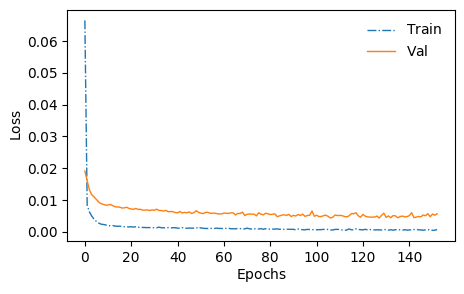

In [17]:
SourcePlotter.plot_loss(history_source_model['loss'], history_source_model['val_loss'], save_fig=False)

10/10 [==============================] - 0s 663us/step


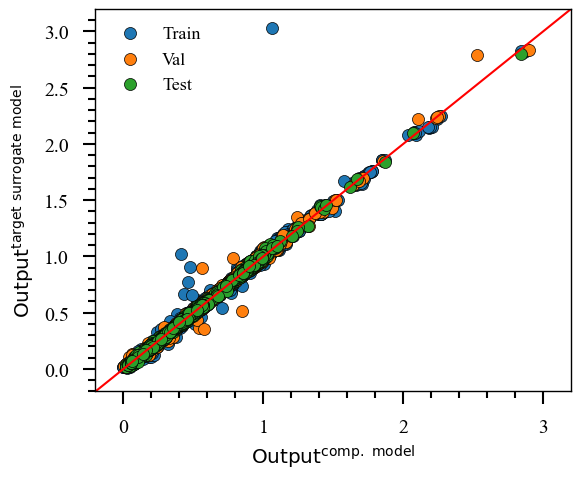

In [18]:
train_predictions = SourceModel.predict(X_train).flatten()
val_predictions = SourceModel.predict(X_val).flatten()
test_predictions = SourceModel.predict(X_test).flatten()

SourcePlotter.plot_model_eval(
            predictions={'train': train_predictions, 'test': test_predictions, 'val': val_predictions},
                        labels={'train': y_train.flatten(), 'test': y_test.flatten(), 'val': y_val.flatten()}, 
                        llimit=-0.2, ulimit=3.2, fig_size=(6, 5),
                        name='source_model_eval', 
                        x_label = r'$\rm Output^{comp.\ model}$',
                        y_label = r'$\rm Output^{target\ surrogate\ model}$')

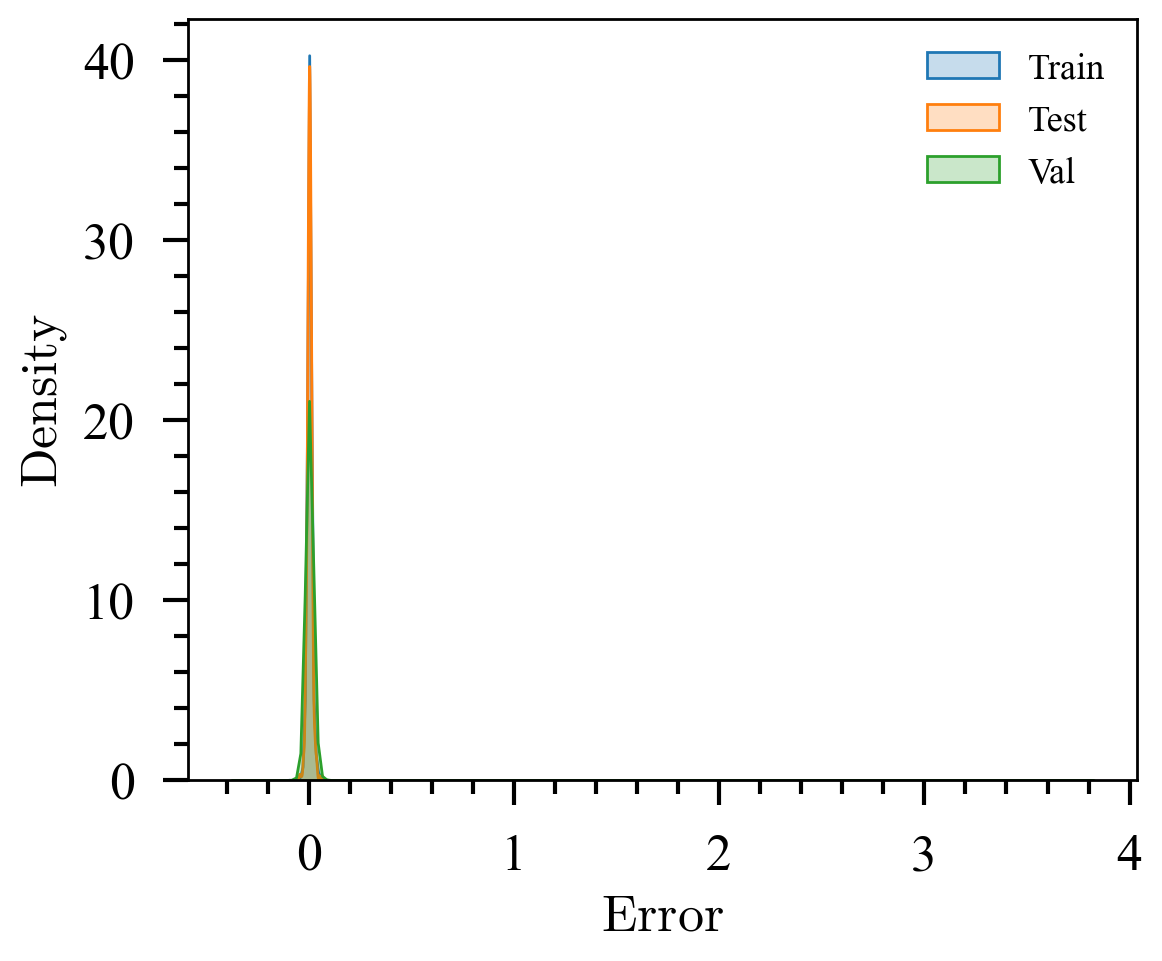

In [19]:
SourcePlotter.plot_pred_distribution(
        error_data={'train': y_train.flatten() - train_predictions,
                    'test': y_test.flatten() - test_predictions,
                    'val': y_val.flatten() - val_predictions},
        fig_size=(6, 5))

In [20]:
SourceModel.save_weights(f'./models/{datetime.now().strftime("%Y-%m-%d")}_source_model_approach_R2.h5')

In [21]:
# accuracy
print('Training set')
print(f'RMSE: {np.sqrt(mean_squared_error(y_train.flatten(), train_predictions)):0.2f}, R^2: {r2_score(y_train.flatten(), train_predictions):0.2f}, MAE: {mean_absolute_error(y_train.flatten(), train_predictions):0.2f}')
print('Validation set')
print(f'RMSE: {np.sqrt(mean_squared_error(y_val.flatten(), val_predictions)):0.2f}, R^2: {r2_score(y_val.flatten(), val_predictions):0.2f}, MAE: {mean_absolute_error(y_val.flatten(), val_predictions):0.2f}')
print('Test set')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test.flatten(), test_predictions)):0.2f}, R^2: {r2_score(y_test.flatten(), test_predictions):0.2f}, MAE: {mean_absolute_error(y_test.flatten(), test_predictions):0.2f}')

Training set
RMSE: 0.02, R^2: 0.99, MAE: 0.01
Validation set
RMSE: 0.08, R^2: 0.94, MAE: 0.01
Test set
RMSE: 0.01, R^2: 1.00, MAE: 0.01


### 3.4 Analyze Feature Importance with SHAP

In [22]:
def disp_shap_bar(shap_values, data, title = 'EC', color = 'red', figsize=(6, 4)):

    # plot bar
    shap.summary_plot(shap_values, data, plot_type="bar", show=False, color=color)

    fig1 = plt.gcf().set_size_inches(figsize)

    plt.rcParams['mathtext.fontset'] = 'cm'
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Times New Roman"
                                            ] + plt.rcParams["font.serif"]
    plt.rcParams['font.size'] = 13

    plt.title(title)
    plt.xlabel(r'$ \rm Feature\ importance$')

    plt.show()

In [64]:
def disp_shap_beeswarm(shap_values, data, title = 'EC', figsize=(6, 4)):

    # plot bee swarm
    shap.summary_plot(shap_values, feature_names=data.columns, features=data, show=False)

    fig1 = plt.gcf().set_size_inches(figsize)

    plt.rcParams['mathtext.fontset'] = 'cm'
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Times New Roman"
                                            ] + plt.rcParams["font.serif"]
    plt.rcParams['font.size'] = 13

    plt.title(title)
    plt.xlabel(r'$ \rm Feature\ importance$')

    plt.show()

In [23]:
sim_data.columns[:-3]

Index(['Ecell', 'Dil', 'Conc', 'Ncell', 'T_tot', 'IEC_r', 'poros_r', 'dens_r',
       'dp'],
      dtype='object')

In [24]:
cols = [
        r'$ \rm E_{cell}$',
        r'$ \rm Conc_{Dil}$',
        r'$ \rm Conc_{Con}$',
        r'$ \rm N{cells}$',
        r'$ \rm Time_{total}$',
        r'$ \rm IEC_{RESIN}$',
        r'$ \rm \phi_{RESIN}$',
        r'$ \rm \rho_{RESIN}$',
        r'$ \rm dp_{RESIN}$']

In [27]:
# merge data
X_train_test_val = np.concatenate((X_train, X_test, X_val), axis=0)
X_train_test_val = X_train_test_val[np.random.choice(X_train_test_val.shape[0], 1000, replace=False)] # sample 1000 points
evaluated_data = pd.DataFrame(X_train_test_val, columns=cols)
explainer = shap.DeepExplainer(SourceModel, X_train_test_val)
shap_values = explainer.shap_values(X_train_test_val)

##### 3.4.1 Salt removal efficiency

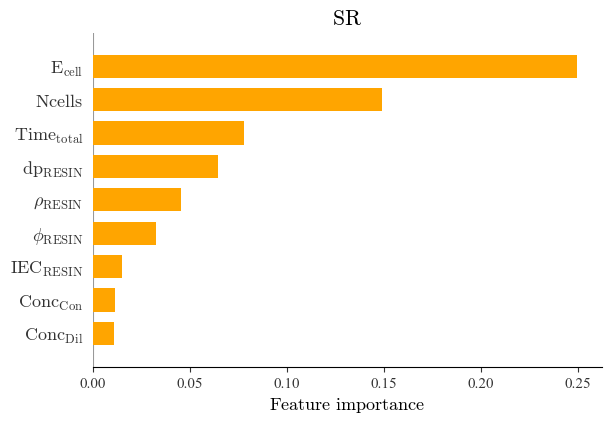

In [28]:
disp_shap_bar(shap_values=shap_values[0], data=evaluated_data, title = r'$ \rm SR$', color = 'orange', figsize=(6, 4))

##### 3.4.1 Energy Consumed

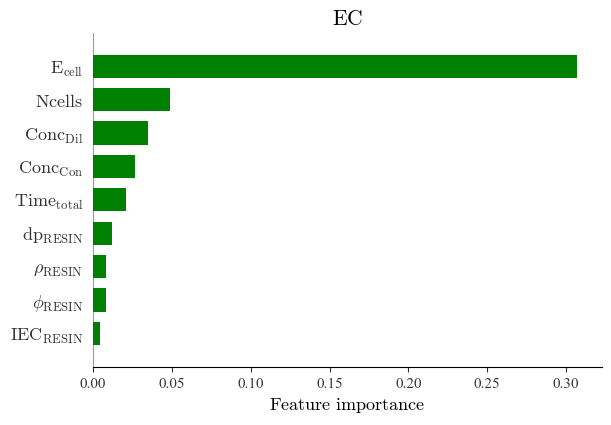

In [29]:
disp_shap_bar(shap_values=shap_values[1], data=evaluated_data, title = r'$ \rm EC$', color = 'green', figsize=(6, 4))

##### 3.4.3 Thermodynamic Efficiency

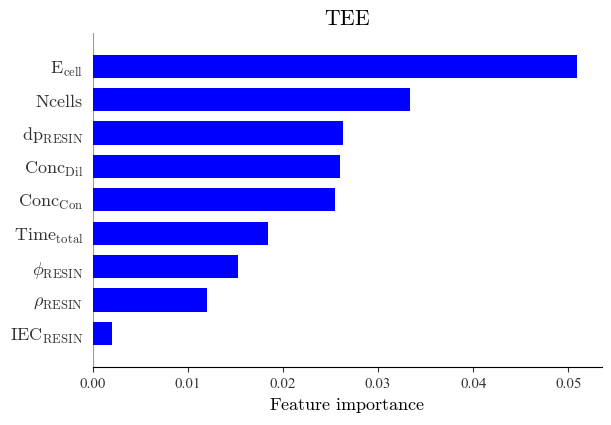

In [30]:
disp_shap_bar(shap_values=shap_values[2], data=evaluated_data, title = r'$ \rm TEE$', color = 'blue', figsize=(6, 4))

In [31]:
SourceModel.save_weights(f"./models/{datetime.now().strftime('%Y-%m-%d')}_source_model_approach_R2.h5")

In [32]:
SourceModel.get_weights()

[array([[ 4.38753158e-01,  4.37552840e-01, -6.83830261e-01,
          7.71057978e-02,  2.27491543e-01, -2.30520397e-01,
          4.08874631e-01, -4.71459627e-01,  2.30267525e-01,
          7.98595250e-02, -9.63566974e-02, -3.44710112e-01,
         -2.56239831e-01, -6.29775822e-02, -3.88924748e-01,
         -1.34852767e-01, -4.14484352e-01,  3.21543515e-01,
          5.62014639e-01,  9.04803276e-02,  3.07108521e-01,
         -5.94828308e-01, -8.95426124e-02, -2.30949178e-01,
          2.71803495e-02,  5.78308925e-02, -3.51731665e-02,
          6.99351206e-02, -2.50505358e-01, -3.27786088e-01,
          3.26632828e-01, -1.31689444e-01, -1.35455698e-01,
         -6.41495734e-02,  1.03276424e-01,  3.75170708e-01,
          1.20867221e-02,  3.35607857e-01,  2.04850987e-01,
         -2.27052975e+00,  1.30368724e-01, -1.78486079e-01,
         -1.98198691e-01, -5.66139771e-03,  2.67518908e-01,
          4.58838828e-02,  1.57657176e-01, -6.10046554e-03,
         -2.78858334e-01,  2.46519774e-0

## Transfer Learning

### 4.2 Load Experimental Data

In [33]:
exp_data = pd.read_csv('./data/processed/2023-12-01-experimental-data_Ecell_Concentrtn_no_membrane_info_CASE_3-speed-up.csv')
print(exp_data.shape)
exp_data.head()

(30, 12)


,Ecell,Dil,Conc,Ncell,T_tot,IEC_r,poros_r,dens_r,dp,SR,EC,TEE
0,1,2.641168,2.910681,4,0.25,0.69,0.265,1.348,0.57,0.152863,0.966967,0.498039
1,1,2.641168,2.910681,4,0.75,0.69,0.265,1.348,0.57,0.438058,1.010693,0.482990
2,1,2.641168,2.910681,4,1.25,0.69,0.265,1.348,0.57,0.678199,1.000828,0.451041
3,1,2.641168,2.910681,4,1.75,0.69,0.265,1.348,0.57,0.851402,1.007712,0.400228
4,1,2.641168,2.910681,4,2.75,0.69,0.265,1.348,0.57,0.990605,1.091498,0.251233


In [34]:
# convert time from hours to minutes
exp_data['T_tot'] = exp_data['T_tot'].apply(lambda x: x*60)
exp_data.head()

,Ecell,Dil,Conc,Ncell,T_tot,IEC_r,poros_r,dens_r,dp,SR,EC,TEE
0,1,2.641168,2.910681,4,15.0,0.69,0.265,1.348,0.57,0.152863,0.966967,0.498039
1,1,2.641168,2.910681,4,45.0,0.69,0.265,1.348,0.57,0.438058,1.010693,0.482990
2,1,2.641168,2.910681,4,75.0,0.69,0.265,1.348,0.57,0.678199,1.000828,0.451041
3,1,2.641168,2.910681,4,105.0,0.69,0.265,1.348,0.57,0.851402,1.007712,0.400228
4,1,2.641168,2.910681,4,165.0,0.69,0.265,1.348,0.57,0.990605,1.091498,0.251233


In [35]:
exp_data = exp_data[desire_columns]
exp_data = exp_data.sample(frac=1, random_state=random_state).reset_index(drop=True)
exp_data.head()

,Ecell,Dil,Conc,Ncell,T_tot,IEC_r,poros_r,dens_r,dp,SR,EC,TEE
0,1,2.709363,2.928619,4,75.0,1.05,0.130,1.276,0.57,0.905294,0.987562,0.369784
1,1,2.569995,2.920128,4,15.0,0.77,0.238,1.442,0.57,0.229597,0.932530,0.495569
2,1,2.699749,2.949353,4,105.0,1.05,0.130,1.276,0.57,0.972821,1.018448,0.298879
3,1,2.569995,2.920128,4,75.0,0.77,0.238,1.442,0.57,0.833625,1.050763,0.407786
4,1,2.680549,2.931789,4,105.0,0.69,0.265,1.348,0.57,0.869057,0.967782,0.391345


In [36]:
source_scaler = f"{datetime.now().strftime('%Y-%m-%d')}_source_EOS_R2_scaler_seed{random_seed}_train_size{(1 - test_size - val_size)*100}percent"
source_scaler

'2024-02-20_source_EOS_R2_scaler_seed104_train_size80.0percent'

In [37]:
# new data from the same distribution but not imputed
DataProcess_transfer = Data(data=exp_data, target_column=['SR', 'EC', 'TEE'], 
                   test_size=0.15, val_size=0.1, random_seed=104,
                   scaler_name='target_EOS_R2')
X_train_transfer, X_test_transfer, X_val_transfer, y_train_transfer, y_test_transfer, y_val_transfer = DataProcess_transfer.preprocess(load_scaler=True, scaler_path= source_scaler) #f'2024-02-14_source_EOS_scaler_seed{random_seed}_train_size{(1 - test_size - val_size)*100}percent')

2024-02-20 09:53:19.674 | INFO     | source.dataPreprocessing:preprocess:37 - mean of Y: 0.7021420348888888
2024-02-20 09:53:19.675 | INFO     | source.dataPreprocessing:preprocess:39 - Initiated Standardizing data
2024-02-20 09:53:19.682 | SUCCESS  | source.dataPreprocessing:preprocess:51 - Standardizing completed
2024-02-20 09:53:19.683 | INFO     | source.dataPreprocessing:preprocess:54 - Initiated train-test split for model evaluation and validation
2024-02-20 09:53:19.685 | SUCCESS  | source.dataPreprocessing:preprocess:59 - Train: ((22, 9), (22, 3)) --> 73.33%
2024-02-20 09:53:19.685 | SUCCESS  | source.dataPreprocessing:preprocess:60 - Val: ((5, 9), (5, 3)) --> 16.67%
2024-02-20 09:53:19.686 | SUCCESS  | source.dataPreprocessing:preprocess:61 - Test: ((3, 9), (3, 3)) --> 10.00%
2024-02-20 09:53:19.686 | SUCCESS  | source.dataPreprocessing:preprocess:63 - train-test split completed


### 4.4 Train Target Model

#### 4.4.1 Train model with frozen weights

In [38]:
X_train_transfer.shape[1]

9

In [39]:
inputs = keras.Input(shape=(X_train_transfer.shape[1],)) # X_train_transfer.shape[1] inputs
x = SourceModel(inputs, training=False) # transfer learning; use the trained model and set training to False
outputs = keras.layers.Dense(3)(x) # 3 outputs
TargetModel = keras.Model(inputs, outputs)
TargetModel.compile(
            optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-3),
            loss="mean_squared_error", metrics=["mean_squared_error", rmse, r_square])

In [40]:
earlystopping=EarlyStopping(monitor="mean_squared_error", patience=40, verbose=1, mode='auto')
TargetModel.fit(X_train_transfer, y_train_transfer, epochs=2000, callbacks=[earlystopping], validation_data=(X_val_transfer, y_val_transfer))

Epoch 1/2000
1/1 [==============================] - 1s 631ms/step - loss: 0.8883 - mean_squared_error: 0.8883 - rmse: 0.9325 - r_square: -8.6378 - val_loss: 0.8263 - val_mean_squared_error: 0.8263 - val_rmse: 0.8968 - val_r_square: -7.0059
Epoch 2/2000
1/1 [==============================] - 0s 19ms/step - loss: 0.7968 - mean_squared_error: 0.7968 - rmse: 0.8815 - r_square: -7.6452 - val_loss: 0.7262 - val_mean_squared_error: 0.7262 - val_rmse: 0.8392 - val_r_square: -6.0357
Epoch 3/2000
1/1 [==============================] - 0s 19ms/step - loss: 0.6897 - mean_squared_error: 0.6897 - rmse: 0.8185 - r_square: -6.4833 - val_loss: 0.6348 - val_mean_squared_error: 0.6348 - val_rmse: 0.7837 - val_r_square: -5.1507
Epoch 4/2000
1/1 [==============================] - 0s 19ms/step - loss: 0.5993 - mean_squared_error: 0.5993 - rmse: 0.7620 - r_square: -5.5028 - val_loss: 0.5911 - val_mean_squared_error: 0.5911 - val_rmse: 0.7550 - val_r_square: -4.7270
Epoch 5/2000
1/1 [=========================

1/1 [==============================] - 0s 12ms/step


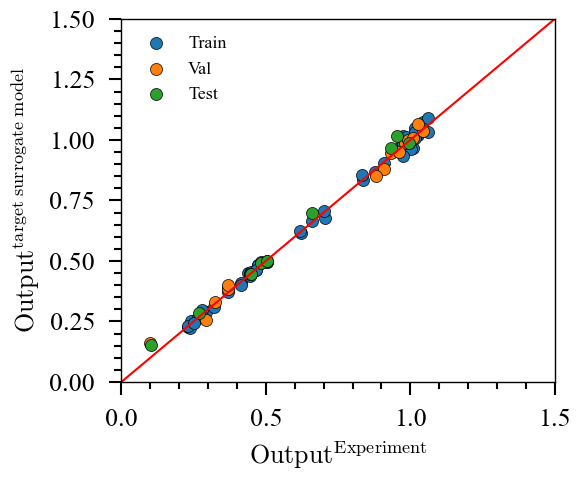

In [41]:
train_predictions_transfer = TargetModel.predict(X_train_transfer).flatten()
val_predictions_transfer = TargetModel.predict(X_val_transfer).flatten()
test_predictions_transfer = TargetModel.predict(X_test_transfer).flatten()

TargetPlotter = Plotters()
TargetPlotter.plot_model_eval(
            predictions={'train': train_predictions_transfer, 'test': test_predictions_transfer, 'val': val_predictions_transfer},
                        labels={'train': y_train_transfer.flatten(), 'test': y_test_transfer.flatten(), 'val': y_val_transfer.flatten()}, 
                        llimit=0, ulimit=1.5, fig_size=(6, 5),
                        name='model_eval', 
                        x_label = r'$\rm Output^{Experiment}$',
                        y_label = r'$\rm Output^{target\ surrogate\ model}$')

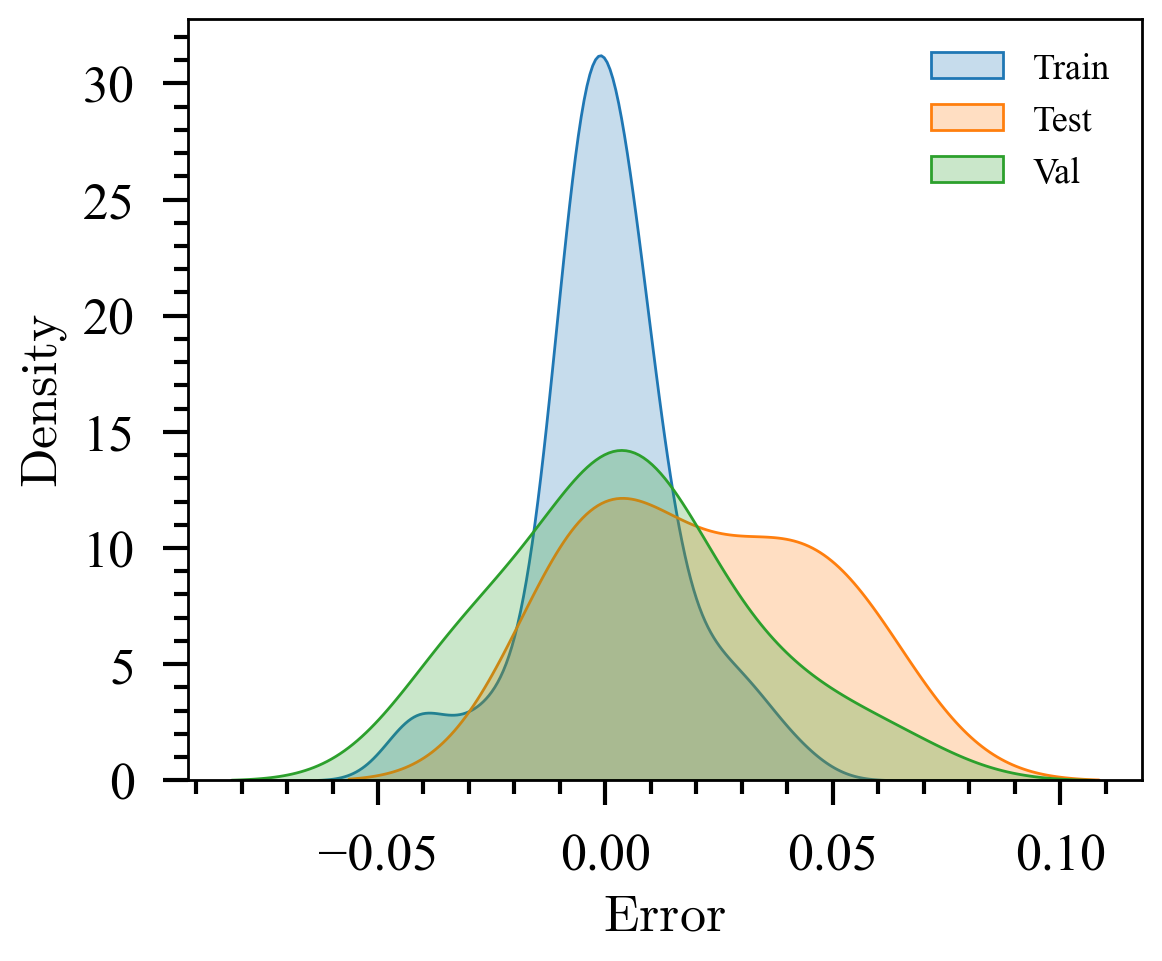

In [42]:
TargetPlotter.plot_pred_distribution(
        error_data={'train': y_train_transfer.flatten() - train_predictions_transfer,
                    'test': y_test_transfer.flatten() - test_predictions_transfer,
                    'val': y_val_transfer.flatten() - val_predictions_transfer},
        fig_size=(6, 5))

In [43]:
# accuracy
print('Training set')
print(f'RMSE: {np.sqrt(mean_squared_error(y_train_transfer.flatten(), train_predictions_transfer)):0.2f}, R^2: {r2_score(y_train_transfer.flatten(), train_predictions_transfer):0.2f}, MAE: {mean_absolute_error(y_train_transfer.flatten(), train_predictions_transfer):0.2f}')
print('Validation set')
print(f'RMSE: {np.sqrt(mean_squared_error(y_val_transfer.flatten(), val_predictions_transfer)):0.2f}, R^2: {r2_score(y_val_transfer.flatten(), val_predictions_transfer):0.2f}, MAE: {mean_absolute_error(y_val_transfer.flatten(), val_predictions_transfer):0.2f}')
print('Test set')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test_transfer.flatten(), test_predictions_transfer)):0.2f}, R^2: {r2_score(y_test_transfer.flatten(), test_predictions_transfer):0.2f}, MAE: {mean_absolute_error(y_test_transfer.flatten(), test_predictions_transfer):0.2f}')

Training set
RMSE: 0.02, R^2: 1.00, MAE: 0.01
Validation set
RMSE: 0.03, R^2: 0.99, MAE: 0.02
Test set
RMSE: 0.03, R^2: 0.99, MAE: 0.03


In [44]:
TargetModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 sequential_1 (Sequential)   (None, 3)                 5542      
                                                                 
 dense_8 (Dense)             (None, 3)                 12        
                                                                 
Total params: 5554 (21.70 KB)
Trainable params: 5554 (21.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### 4.4.2 Train (fine-tune) model with unfrozen weights

In [45]:
# Unfreeze the base model
SourceModel.trainable = True
# compile the model
TargetModel.compile(
            optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-5),
            loss="mean_squared_error", metrics=["mean_squared_error", rmse, r_square])
# train model
earlystopping=EarlyStopping(monitor="mean_squared_error", patience=40, verbose=1, mode='auto')
TargetModel.fit(X_train_transfer, y_train_transfer, epochs=5, callbacks=[earlystopping], validation_data=(X_val_transfer, y_val_transfer))

Epoch 1/5
1/1 [==============================] - 1s 732ms/step - loss: 2.4919e-04 - mean_squared_error: 2.4919e-04 - rmse: 0.0142 - r_square: 0.9973 - val_loss: 6.6994e-04 - val_mean_squared_error: 6.6994e-04 - val_rmse: 0.0252 - val_r_square: 0.9935
Epoch 2/5
1/1 [==============================] - 0s 18ms/step - loss: 2.4922e-04 - mean_squared_error: 2.4922e-04 - rmse: 0.0142 - r_square: 0.9973 - val_loss: 6.7088e-04 - val_mean_squared_error: 6.7088e-04 - val_rmse: 0.0252 - val_r_square: 0.9935
Epoch 3/5
1/1 [==============================] - 0s 17ms/step - loss: 2.4915e-04 - mean_squared_error: 2.4915e-04 - rmse: 0.0142 - r_square: 0.9973 - val_loss: 6.7163e-04 - val_mean_squared_error: 6.7163e-04 - val_rmse: 0.0252 - val_r_square: 0.9935
Epoch 4/5
1/1 [==============================] - 0s 20ms/step - loss: 2.4908e-04 - mean_squared_error: 2.4908e-04 - rmse: 0.0142 - r_square: 0.9973 - val_loss: 6.7173e-04 - val_mean_squared_error: 6.7173e-04 - val_rmse: 0.0252 - val_r_square: 0.9935

In [46]:
TargetModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 sequential_1 (Sequential)   (None, 3)                 5542      
                                                                 
 dense_8 (Dense)             (None, 3)                 12        
                                                                 
Total params: 5554 (21.70 KB)
Trainable params: 5554 (21.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


1/1 [==============================] - 0s 17ms/step


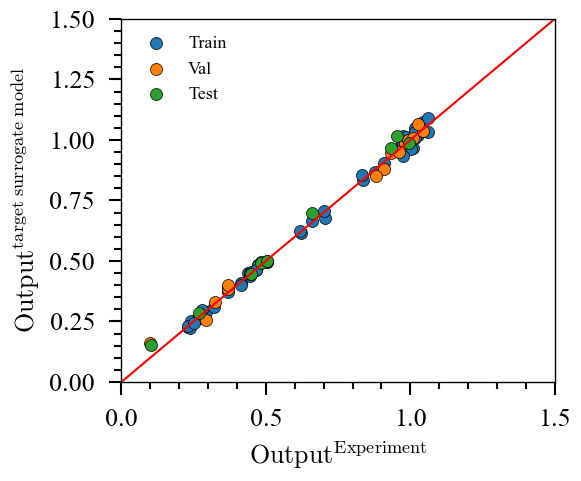

In [47]:
train_predictions_transfer = TargetModel.predict(X_train_transfer).flatten()
val_predictions_transfer = TargetModel.predict(X_val_transfer).flatten()
test_predictions_transfer = TargetModel.predict(X_test_transfer).flatten()

TargetPlotter = Plotters()
TargetPlotter.plot_model_eval(
            predictions={'train': train_predictions_transfer, 'test': test_predictions_transfer, 'val': val_predictions_transfer},
                        labels={'train': y_train_transfer.flatten(), 'test': y_test_transfer.flatten(), 'val': y_val_transfer.flatten()}, 
                        llimit=0, ulimit=1.5, fig_size=(6, 5),
                        name='model_eval', 
                        x_label = r'$\rm Output^{Experiment}$',
                        y_label = r'$\rm Output^{target\ surrogate\ model}$')

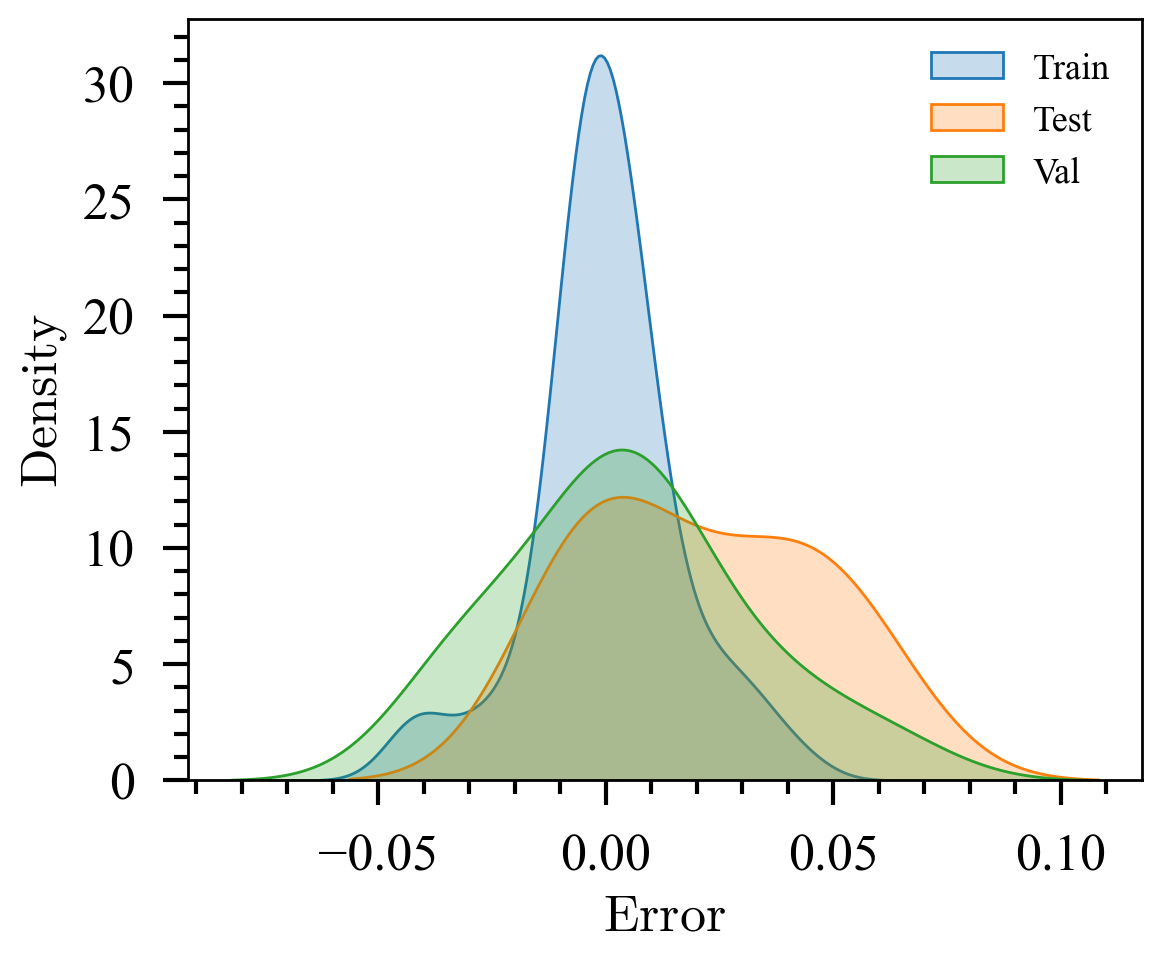

In [48]:
TargetPlotter = Plotters()
TargetPlotter.plot_pred_distribution(
        error_data={'train': y_train_transfer.flatten() - train_predictions_transfer,
                    'test': y_test_transfer.flatten() - test_predictions_transfer,
                    'val': y_val_transfer.flatten() - val_predictions_transfer},
        fig_size=(6, 5))

In [49]:
# accuracy
print('Training set')
print(f'RMSE: {np.sqrt(mean_squared_error(y_train_transfer.flatten(), train_predictions_transfer)):0.2f}, R^2: {r2_score(y_train_transfer.flatten(), train_predictions_transfer):0.2f}, MAE: {mean_absolute_error(y_train_transfer.flatten(), train_predictions_transfer):0.2f}')
print('Validation set')
print(f'RMSE: {np.sqrt(mean_squared_error(y_val_transfer.flatten(), val_predictions_transfer)):0.2f}, R^2: {r2_score(y_val_transfer.flatten(), val_predictions_transfer):0.2f}, MAE: {mean_absolute_error(y_val_transfer.flatten(), val_predictions_transfer):0.2f}')
print('Test set')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test_transfer.flatten(), test_predictions_transfer)):0.2f}, R^2: {r2_score(y_test_transfer.flatten(), test_predictions_transfer):0.2f}, MAE: {mean_absolute_error(y_test_transfer.flatten(), test_predictions_transfer):0.2f}')

Training set
RMSE: 0.02, R^2: 1.00, MAE: 0.01
Validation set
RMSE: 0.03, R^2: 0.99, MAE: 0.02
Test set
RMSE: 0.03, R^2: 0.99, MAE: 0.03


In [50]:
TargetModel.save_weights(f'./models/{datetime.now().strftime("%Y-%m-%d")}_target_model_approach_R2.h5')

In [51]:
TargetModel.get_weights()

[array([[ 4.20650750e-01,  4.61132109e-01, -6.69597030e-01,
          1.00183479e-01,  2.14947984e-01, -1.98264390e-01,
          3.82346749e-01, -4.41112965e-01,  2.06167966e-01,
          7.98595250e-02, -9.63566974e-02, -3.43173921e-01,
         -2.56239831e-01, -6.26075491e-02, -3.69031578e-01,
         -1.02223061e-01, -4.14484352e-01,  2.88944751e-01,
          5.40376067e-01,  9.04803276e-02,  3.27107906e-01,
         -5.94828308e-01, -8.95426124e-02, -2.30949178e-01,
          7.13080764e-02,  1.05318472e-01, -3.51731665e-02,
          7.08599836e-02, -2.19420224e-01, -3.42702687e-01,
          3.14165413e-01, -1.30067244e-01, -1.35455698e-01,
         -6.41495734e-02,  1.23136394e-01,  3.63227308e-01,
          9.94729344e-03,  3.35607857e-01,  2.04850987e-01,
         -2.27052975e+00,  1.55901358e-01, -1.16481453e-01,
         -1.98198691e-01,  3.82746011e-02,  2.67518908e-01,
          6.44347817e-02,  1.57657176e-01, -6.10046554e-03,
         -2.78858334e-01,  2.65783548e-0

In [52]:
for i in range(len(TargetModel.get_weights())):

    print(f'Layer {i} shape: {TargetModel.get_weights()[i].shape}')

Layer 0 shape: (9, 50)
Layer 1 shape: (50,)
Layer 2 shape: (50, 42)
Layer 3 shape: (42,)
Layer 4 shape: (42, 29)
Layer 5 shape: (29,)
Layer 6 shape: (29, 50)
Layer 7 shape: (50,)
Layer 8 shape: (50, 3)
Layer 9 shape: (3,)
Layer 10 shape: (3, 3)
Layer 11 shape: (3,)


### 4.5 Analyze Feature Importance with SHAP

In [54]:
# merge data
X_train_test_val_transfer = X_train_test_val # use the same data as the source model
evaluated_data_transfer = pd.DataFrame(X_train_test_val_transfer, columns=cols)
explainer_transfer = shap.DeepExplainer(TargetModel, X_train_test_val_transfer)
shap_values_transfer = explainer_transfer.shap_values(X_train_test_val_transfer)

##### 4.5.1 Salt removal efficiency

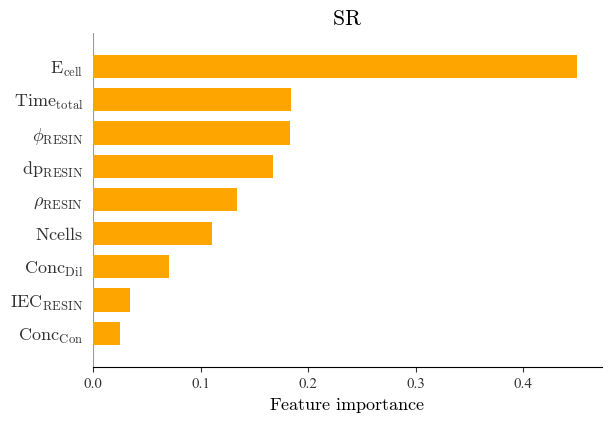

In [55]:
disp_shap_bar(shap_values=shap_values_transfer[0], data=evaluated_data_transfer, title = r'$ \rm SR$', color = 'orange', figsize=(6, 4))

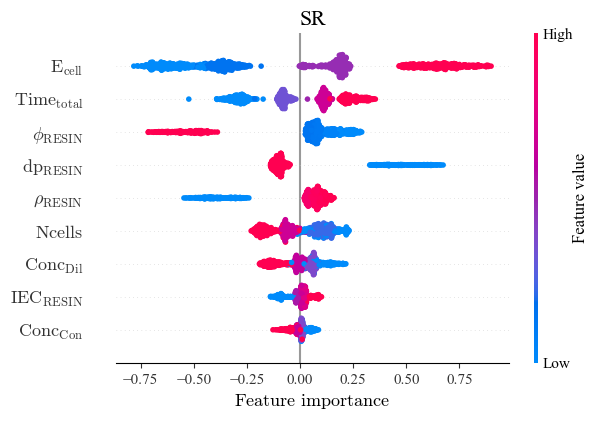

In [66]:
disp_shap_beeswarm(shap_values_transfer[0], evaluated_data_transfer, title = 'SR', figsize=(6, 4))

##### 4.5.2 Energy Consumed

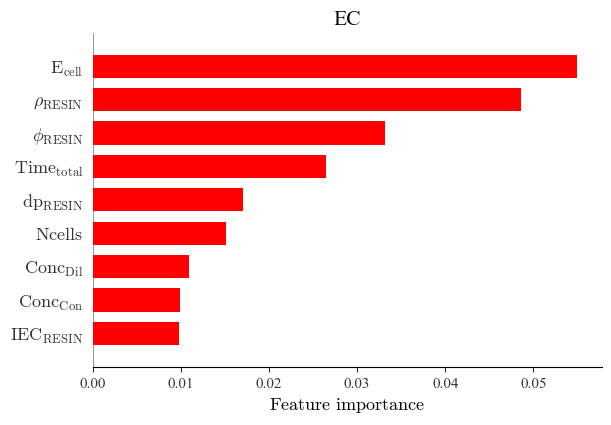

In [56]:
disp_shap_bar(shap_values_transfer[1], evaluated_data_transfer, title = 'EC', color = 'red', figsize=(6, 4))

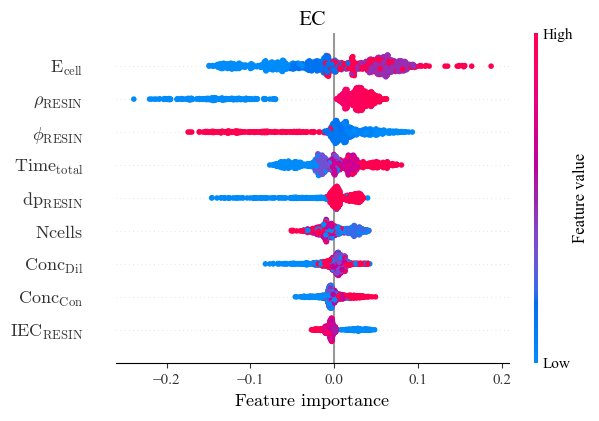

In [65]:
disp_shap_beeswarm(shap_values_transfer[1], evaluated_data_transfer, title = 'EC', figsize=(6, 4))

##### 4.5.3 Thermodynamics Efficiency

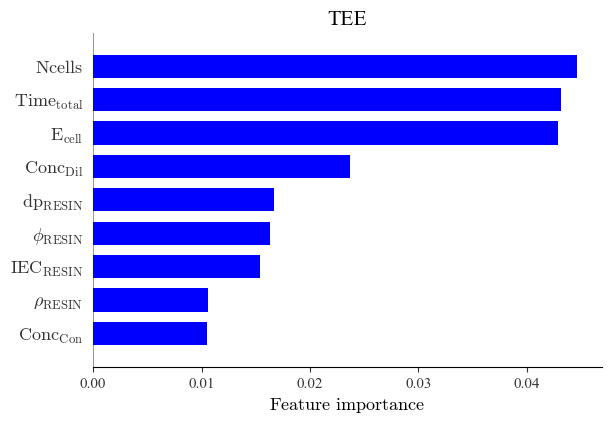

In [57]:
disp_shap_bar(shap_values_transfer[2], evaluated_data_transfer, title = 'TEE', color = 'blue', figsize=(6, 4))

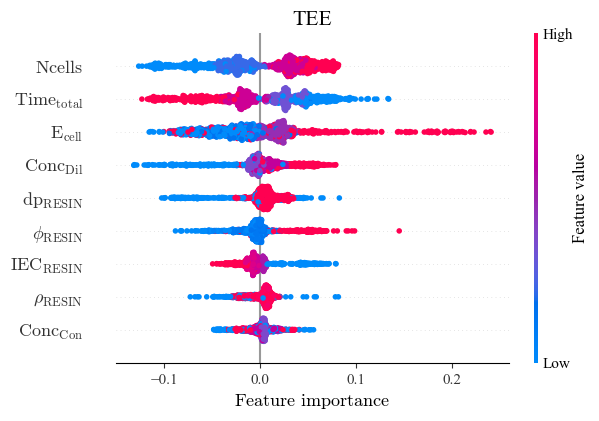

In [68]:
disp_shap_beeswarm(shap_values_transfer[2], evaluated_data_transfer, title = 'TEE', figsize=(6, 4))